(ch_geetrend)=
# Trend analysis

## Packages

In [1]:
import ee
import geemap
import pandas as pd
import numpy as np
import geopy_ee_ts_fun as geopy

try:
    ee.Initialize(project="ee-pflugmacher")
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project="ee-pflugmacher")

## Set up map window

In this exercise, we are going to map trends. First, we define a `region`, a coordinate reference system `crs`, and a `scale`(pixel size) or affine transformation `crsTransform`.

In [2]:
region = ee.Geometry.Polygon(
        [[[12.901495385988614, 53.14672196059798],
          [12.901495385988614, 52.850010520689125],
          [13.426092553957364, 52.850010520689125],
          [13.426092553957364, 53.14672196059798]]])
scale = 20
crs = 'EPSG:3035'

In [3]:
Map = geemap.Map()
Map.centerObject(region, zoom=11)
Map

Map(center=[52.99848490048411, 13.163793969972417], controls=(WidgetControl(options=['position', 'transparent_…

### Visualization parameters

In [4]:
# Sentinel-2 surface reflectance
s2Vis = {"bands": ["B4", "B3", "B2"], "min":0, "max": 1200}

# NDVI color palette
ndviVis = {"palette": ['white', 'green'], "min":0.2, "max": 1}

## Sentinel-2 data

The code block below filters the Sentinel-2 collection, masks clouds and calculats NDVI. The cloud masking approach uses the AI-based [Cloud Score+](https://medium.com/google-earth/all-clear-with-cloud-score-bd6ee2e2235e) available in the [Cloud Score+ Harmonized-S2 dataset](https://developers.google.com/earth-engine/datasets/catalog/GOOGLE_CLOUD_SCORE_PLUS_V1_S2_HARMONIZED#bands). The Sentinel-2 harmonized dataset fixes different scaling factors in the original Sentinel-2 dataset.

In [5]:
dateFilter = ee.Filter.And(ee.Filter.dayOfYear(200, 365), 
                           ee.Filter.date(ee.Date.fromYMD(2018, 1, 1), 
                                          ee.Date.fromYMD(2021, 12, 31)))

# Harmonized Sentinel-2 Level 2A collection.
s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

# Cloud Score+ image collection. Note Cloud Score+ is produced from Sentinel-2
# Level 1C data and can be applied to either L1C or L2A collections.
csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')

# Use 'cs' or 'cs_cdf', depending on your use case; see docs for guidance.
QA_BAND = 'cs_cdf'

# The threshold for masking; values between 0.50 and 0.65 generally work well.
# Higher values will remove thin clouds, haze & cirrus shadows.
CLEAR_THRESHOLD = 0.60

def mask_s2(image):
    return image.updateMask(image.select(QA_BAND).gte(CLEAR_THRESHOLD))

s2m = s2.filterBounds(region) \
        .filter(dateFilter) \
        .linkCollection(csPlus, [QA_BAND]) \
        .map(mask_s2)

# Create NDVI Collection from masked Sentinel-2 data
ndviS2 = s2m.map(geopy.calcNdviS2)

In [6]:
ndviS2

## Harmonic function


In this exercise, I fit a first-order harmonic model of the form:

$\hat{y}(t) = \beta_0 + \beta_1 t + \beta_2 cos(2\pi \frac{t}{T}) + \beta_3 sin(2\pi \frac{t}{T})$

The harmonic model is fitted to every pixel, i.e., we will estimate the parameters $\beta_0$, $\beta_1$, $\beta_2$, and $\beta_3$ for every pixel. The $\beta$´s are parameters for $t$ and different transformations of $t$, where $t$ is time in days or (fractional) years and $T$ is the period. The period $T$ describes how many $t$ it takes to complete a full harmonic cylce. For example, $T$ is 1 if $t$ is in years and 365 if $t$ is in days. The model estimates $\hat{y}$, which is the NDVI in our case.

The first step is to **assemble the response (NDVI) and predictor variables**. The function `addPredictorVariables()` adds four bands to an NDVI image. The four bands are the intercept and the predictors, i.e., $t$ and its harmonic tranformations. The band `constant` has the pixel value 1 and is required to fit an intercept. The band `time`, associated with parameter $\beta_1$, is time $t$ expressed in years since January 1st 1970. It is a fractional value with decimal places. Now, the predictor variables do not vary for a specific NDVI image, i.e., $t$ is constant for a specific image. However, recall that we fit time series to individual pixels. You also see that we can create an image with a scalar value simply by calling `ee.Image(scalar)`. Earth engine will expand the scalar value in space as needed, i.e., defined by the output region.

In [7]:
def addPredictorVariables(image):
    
    date = ee.Date(image.get('system:time_start'))
    time = date.difference(ee.Date('1970-01-01'), 'year')
    sin = time.multiply(2 * np.pi ).sin()
    cos = time.multiply(2 * np.pi ).cos()
    
    predictors = ee.Image([sin, cos, time, 1]).float()

    return predictors.addBands(image.select(['ndvi'])) \
                     .rename(['sin', 'cos', 'time', 'constant', 'ndvi']) \
                     .set('system:time_start', image.get('system:time_start'))

trainingCollection = ndviS2.map(addPredictorVariables)

### Fit model

Now, we can **estimate the $\beta$´s using linear regression**. The reducer is not aware of variable names and their order in the image. It assumes the last variable to be the response variable. So, we make sure that NDVI (`responseName`) is selected last.

The output of the regression reduction (`trend`) contains two bands: `coefficients` and `residuals`. However, `trend` is an array image and not a standard image. An array image can store an entire vector/array in each pixel not just a scalar value. For example, an array image can store a six-band image in a single band, where each pixel would contain a vector of length six. However, pixels in an array image do not have to store vectors of the same length. In our case, the `coefficients` band stores the coefficients in a 4x1 array in each pixel. To turn this into a four band image, we need to apply `arrayProject` (removes the second axis of length 1) and `arrayFlatten` (puts every array element into its own band).

In [8]:
responseName = ee.String('ndvi')
predictorNames = ee.List(['constant', 'time', 'cos', 'sin'])

trend = trainingCollection.select(predictorNames.add(responseName)) \
            .reduce(ee.Reducer.linearRegression(predictorNames.length(), 1))

coefficients = trend.select('coefficients') \
                    .arrayProject([0]) \
                    .arrayFlatten([predictorNames])

Visualizing the coefficients reveals different patterns in seasonality and trend (`time`) for different land cover types. The harmonic model compresse the NDVI time series into a few parameters that still represent the spectral-temporal dynamics. NOTE: the visualization of the map can take a while. The pixelwise trend fitting is processing intenstive. Keep the zoom level steady. The process restarts every time you zoom in or out.

In [9]:
Map.addLayer(coefficients.select(['sin']), {"min": -0.23, "max":0.1}, 'sin')
Map.addLayer(coefficients.select(['cos']), {"min": -0.23, "max":0.1}, 'cos')
Map.addLayer(coefficients.select(['time']), {"min": -0.03, "max":0.03, "palette": ['red', 'white', 'green']}, 'time')

### Fitted values

We can obtain the fitted NDVI values to better understand how our models fits the data. To do this, we need to write a funciton that takes a training image (containg NDVI, $t$ and the harmonic terms) and applies the estimated coefficients. We then map that function to the training collection to obtain a collection of fitted NDVI images.

In [10]:
def linearFit(image):
    fit = image.select(predictorNames) \
               .multiply(coefficients) \
               .reduce('sum') \
               .rename('fitted')
    return image.addBands(fit)

fitted = trainingCollection.map(linearFit)

## Pixel observations

Let's evaluate the model fit for individual pixel observations. To visualize these pixels, we first extract the NDVI time series for a single pixel. Second, we extract the coefficients. And third, we extract the fitted values.

### Extract NDVI time series

In [11]:
pt_dbf = ee.Geometry.Point([13.18496707443565,53.06189771226909])
pt_ag1 = ee.Geometry.Point([13.134970698398053, 53.06835763719942])
pt_ag2 = ee.Geometry.Point([13.047938380282819, 53.04421500010952])
pt_ag3 = ee.Geometry.Point([13.0798673963961, 53.010351264908145])

In [12]:
ee_vals = ndviS2.getRegion(geometry=pt_dbf, scale=scale, crs=crs)

# use data converter to return values as python list
vals = ee.data.computeValue(ee_vals)
vals[0:3]


[['id', 'longitude', 'latitude', 'time', 'ndvi'],
 ['20180721T102021_20180721T102024_T32UQD',
  13.184850310654017,
  53.06195679914768,
  1532168424461,
  0.8832853025936599],
 ['20180721T102021_20180721T102024_T33UUU',
  13.184850310654017,
  53.06195679914768,
  1532168424461,
  0.8791130185979972]]

In [13]:
# convert returned list to pandas data.frame
# the first element (vals[0]) contains the column names
# the second element contains the first observation and so on 
df = pd.DataFrame(vals[1:], columns=vals[0]).dropna()

# extract date string and convert it to date object
df['date'] = pd.to_datetime(df.id.str.slice(0, 8))

 # copy date to row index
df.index  = df.date
df.head()


id  longitude   latitude  \
date                                                                       
2018-07-21  20180721T102021_20180721T102024_T32UQD   13.18485  53.061957   
2018-07-21  20180721T102021_20180721T102024_T33UUU   13.18485  53.061957   
2018-07-23  20180723T101019_20180723T101036_T32UQD   13.18485  53.061957   
2018-07-23  20180723T101019_20180723T101036_T33UUU   13.18485  53.061957   
2018-07-26  20180726T102019_20180726T102150_T32UQD   13.18485  53.061957   

                     time      ndvi       date  
date                                            
2018-07-21  1532168424461  0.883285 2018-07-21  
2018-07-21  1532168424461  0.879113 2018-07-21  
2018-07-23  1532340636891  0.903789 2018-07-23  
2018-07-23  1532340636891  0.909469 2018-07-23  
2018-07-26  1532600510652  0.886746 2018-07-26

The dataset may contain duplicate values due to the overlapping Sentinel-2 tiles. That is, there should only be one observation for a given day. So, let's drop duplicate values.

In [14]:
df = df.drop_duplicates(subset=['date'])
df.head()

id  longitude   latitude  \
date                                                                       
2018-07-21  20180721T102021_20180721T102024_T32UQD   13.18485  53.061957   
2018-07-23  20180723T101019_20180723T101036_T32UQD   13.18485  53.061957   
2018-07-26  20180726T102019_20180726T102150_T32UQD   13.18485  53.061957   
2018-07-31  20180731T102021_20180731T102024_T32UQD   13.18485  53.061957   
2018-08-07  20180807T101021_20180807T101024_T32UQD   13.18485  53.061957   

                     time      ndvi       date  
date                                            
2018-07-21  1532168424461  0.883285 2018-07-21  
2018-07-23  1532340636891  0.903789 2018-07-23  
2018-07-26  1532600510652  0.886746 2018-07-26  
2018-07-31  1533032424462  0.914293 2018-07-31  
2018-08-07  1533636624457  0.902853 2018-08-07

Now we can plot column `ndvi` against the dataframe index, which is `date`.

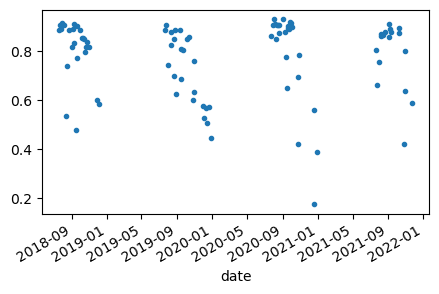

In [15]:
df.ndvi.plot(style='.', figsize=(5,3));

### Extract coefficients

We can extract the coefficients of the harmonic model for a single pixel using a reducer. Coefficients is an `ee.Image`, which has the `sampleRegions` reducer. You may get an exception "User memory limit exceeded". To avoid this error, you can limit the processed area size or save intermediate results to your assets.

In [16]:
# returns feature collection
ee_coef = coefficients.sampleRegions(collection=pt_dbf, scale=scale, 
                                     projection=crs)

# extracts feature collection (server-side) to pandas dataFrame (client-side)
pt_coef = ee.data.computeFeatures({'expression': ee_coef, 'fileFormat': 'PANDAS_DATAFRAME'})
pt_coef.drop(columns="geo", inplace=True)
pt_coef

constant       cos       sin      time
0  0.723115 -0.162878 -0.213892 -0.002603

### Extract fitted values

Let's extract the fitted NDVI values for a single pixel. Note, `fitted` is an `ee.ImageCollection`, which we can reduce with `getRegion()`. The output is a list that we can turn into a Pandas DataFrame for further analysis.

In [17]:
ee_fit = fitted.getRegion(geometry=pt_dbf, scale=scale, crs=crs)
pt_fit = ee.data.computeValue(ee_fit)

dfit = pd.DataFrame(pt_fit[1:], columns=pt_fit[0]).dropna() # create DataFrame and drop NA
dfit["date"] = pd.to_datetime(dfit.id.str.slice(0, 8)) # extract date from tile-id
dfit.index = dfit.date # put date into index to facilitate plotting
dfit = dfit.drop_duplicates(subset=['date']) # EE fits to duplicate values
dfit = dfit.iloc[:, np.delete(np.arange(dfit.shape[1]), 4)] # drop first 'time' column
dfit.iloc[:,4:].head(3)

cos       time  constant      ndvi    fitted       date
date                                                                    
2018-07-21 -0.946117  48.552486         1  0.883285  0.820100 2018-07-21
2018-07-23 -0.934459  48.557941         1  0.903789  0.825084 2018-07-23
2018-07-26 -0.914793  48.566177         1  0.886746  0.832095 2018-07-26

### Visualize extracted values

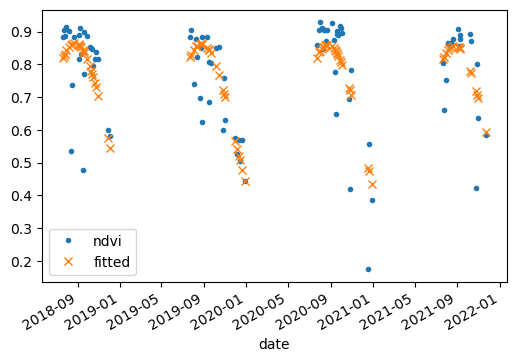

In [18]:
dfit[["ndvi", "fitted"]].plot(style=['.', 'x'], figsize=(6,4));

### Make predictions

In [19]:
def fit_harmonic(t, constant, time, sin, cos, period=1):
    
    result = constant + time*t + \
                sin*np.sin(2.0 * np.pi * (t / period)) + \
                cos*np.cos(2.0 * np.pi * (t / period))
    return result

def fit_trend(t, constant, time, sin, cos ):
    result = constant + time*t
    return result
    

In [20]:
# date difference in days
t = pd.date_range('2018-01-01', '2021-12-31', freq='D') 

# date difference in yeas
td = (t - pd.to_datetime('1970-01-01')) / np.timedelta64(1, 'D') / 365.25

# convert params stored in data frame to dictionary
params = pt_coef.to_dict(orient='records')[0]

# the result is a pandas.core.indexes.numeric.Float64Index
# we can extract the values of t with t.values
fitted_harm = fit_harmonic(td.values, **params)

fitted_trend = fit_trend(td.values, **params)

dfm = pd.DataFrame({'ndvi_harm':fitted_harm, 
                    'ndvi_trend': fitted_trend}, index=t)

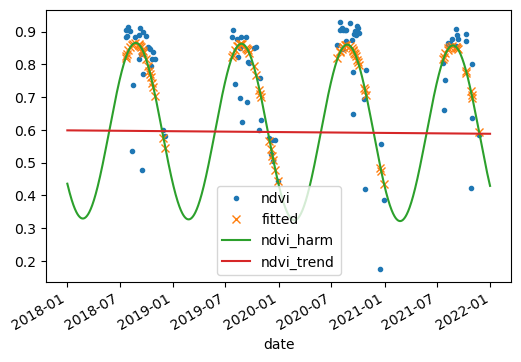

In [21]:
ax = dfit[["ndvi", "fitted"]].plot(style=['.', 'x'], figsize=(6,4))
dfm.plot(ax=ax);

## Mann-Kendall

https://developers.google.com/earth-engine/tutorials/community/nonparametric-trends

## Sen's slope

https://developers.google.com/earth-engine/tutorials/community/nonparametric-trends#sens_slope

## Further reading

* [Time Series Modeling (EE Community Tutorial)](https://developers.google.com/earth-engine/tutorials/community/time-series-modeling)
* Time Series Analysis in Earth Engine (Lecture: Nick Clinton): [Video](https://www.youtube.com/watch?v=xQGNAYL7z80)
* Time Series Analysis in Earth Engine (Lecture: Nick Clinton): [Slides](https://docs.google.com/presentation/d/1J1rUtf-bkfaJwYJY-tU17kzKI4U8FnF7Q2_VWqWdaak/edit#slide=id.g4954714e1_18)